# PREDICT ANNUAL RETURNS

In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score
from IPython.display import FileLink
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
TrainDataPath = './BW2017Data/train.csv'
TestDataPath = './BW2017Data/test.csv'

# Loading the Training and Test Dataset
TrainData = pd.read_csv(TrainDataPath)
TestData = pd.read_csv(TestDataPath)

# Exploring The Dataset

In [45]:
print("Training Dataset Shape:")
print(TrainData.shape)
print("\n")
print("Training Dataset Columns/Features:")
print(TrainData.dtypes)
TrainData.head()

Training Dataset Shape:
(9366, 18)


Training Dataset Columns/Features:
portfolio_id       object
desk_id            object
office_id          object
pf_category        object
start_date          int64
sold              float64
country_code       object
euribor_rate      float64
currency           object
libor_rate        float64
bought            float64
creation_date       int64
indicator_code     object
sell_date           int64
type               object
hedge_value        object
status             object
return            float64
dtype: object


,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return
0,PF00001002,DSK00001001,OFF00001002,B,20040720,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,20040720,NaN,20040812,B,NaN,NaN,0.02496
1,PF00001003,DSK00001002,OFF00001001,A,20040709,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,20040723,NaN,20040812,C,NaN,NaN,0.05496
2,PF00001005,DSK00001004,OFF00001001,A,20040723,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,20040723,NaN,20040817,A,NaN,NaN,0.02496
3,PF00001006,DSK00001005,OFF00001001,A,20040609,164813000.0,T,0.02074,USD,2.332216,1.645088e+08,20040723,NaN,20040713,A,NaN,NaN,0.02496
4,PF00001007,DSK00001005,OFF00001002,B,20040609,140800000.0,T,0.02074,USD,2.332216,1.405402e+08,20040723,NaN,20040713,B,NaN,NaN,0.02496


In [46]:
print("Test Dataset Shape:")
print(TestData.shape)
print("\n")
print("Test Dataset Columns/Features:")
print(TestData.dtypes)
TestData.head()

Test Dataset Shape:
(4801, 17)


Test Dataset Columns/Features:
portfolio_id       object
desk_id            object
office_id          object
pf_category        object
start_date          int64
sold              float64
country_code       object
euribor_rate      float64
currency           object
libor_rate        float64
bought            float64
creation_date       int64
indicator_code     object
sell_date           int64
type               object
hedge_value        object
status             object
dtype: object


,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status
0,PF00001001,DSK00001001,OFF00001001,A,20040720,171831000.0,T,0.02074,USD,2.332216,1.715337e+08,20040720,NaN,20040812,A,NaN,NaN
1,PF00001004,DSK00001003,OFF00001002,B,20040723,56485000.0,T,0.02074,USD,2.332216,5.638038e+07,20040723,NaN,20040719,B,NaN,NaN
2,PF00001009,DSK00001007,OFF00001001,A,20040607,41734000.0,T,0.02074,USD,2.332216,4.166179e+07,20040726,NaN,20040709,A,NaN,NaN
3,PF00001013,DSK00001011,OFF00001001,A,20040716,82951000.0,T,0.02074,USD,2.332216,8.250936e+07,20040726,NaN,20041019,A,NaN,NaN
4,PF00001014,DSK00001012,OFF00001001,A,20040713,73293000.0,T,0.02074,USD,2.332216,7.317055e+07,20040726,NaN,20040813,A,NaN,NaN


In [47]:
# Now Checking For Any Missing Values
print("Training Dataset Missing Value Columns:")
print(TrainData.isnull().sum())
print("\n")
print("Test Dataset Missing Value Columns:")
print(TestData.isnull().sum())

Training Dataset Missing Value Columns:
portfolio_id         0
desk_id           3665
office_id            0
pf_category          0
start_date           0
sold                 2
country_code         0
euribor_rate         0
currency             0
libor_rate         474
bought               2
creation_date        0
indicator_code    5699
sell_date            0
type                 0
hedge_value       5701
status            3084
return               0
dtype: int64


Test Dataset Missing Value Columns:
portfolio_id         0
desk_id           1948
office_id            0
pf_category          0
start_date           0
sold                 0
country_code         0
euribor_rate         0
currency             0
libor_rate         265
bought               0
creation_date        0
indicator_code    2851
sell_date            0
type                 0
hedge_value       2851
status            1457
dtype: int64


# Now Strategy To Tackle The Dataset (Data Preprocessing)

1. **portfolio_id** - This Column has no null value neither in the Training set nor in the Test set, while exploring this feature I found out that each value is almost unique from the rest of all values, therefore I am not going to consider this feature for our model because it will not help our model to predict better.

2. **desk_id** - After a lot of experimentation I found out that this feature is very important without including this our model will not acheive high accuracy. This feature has value of type for ex DSK00001001 so I am going to extract only the 1001 and then convert this column numbers into float.

3. **office_id** - This feature has only two unique values i.e. OFF00001001 & OFF00001002, now we will convert this feature into dummy variables and thus having two columns.

4. **pf_category** - This feature has 5 categories for Training Set and 4 categories for Test Set, therefore first of all I will delete the rows in the training set which contains that extra 5 category and after that I will convert this column into dummy variable columns.

5. **start_date**, **creation_date**, **sell_date** - I am going to delete these 3 columns but before that I will create 2 new feature **"sell date - creation date"** and **"creation date - start date"**

6. **sold**, **bought** - I found out that these columns have 2 missing value from the same row, so we will delete these 2 rows and nothing to do much with these columns.

7. **indicator_code**, **hedge_value**, **status** - These 3 columns have a lot of missing values so I will replace all the null values with False, I have tried to delete these 3 columns and had put other values but replacing with False gives the best score.

8. **libor_rate** - I had filled the missing values with the median() value both in Train and Test Set.

9. **euribor_rate** - Just keep this column as it is. NO PREPROCESSING in this column.

10. **type** , **country_code**, **currency** - I Just did what I did with **pf_category** i.e. converted them into dummy variable, and remove those rows with categories which are not present in test data.

# DATA PREPROCESSING STEP

In [48]:
# First of all we will create new features using our Date Columns
# Therefore converting Date Columns to appropriate format

TrainData['start_date'] = pd.to_datetime(TrainData['start_date'], format = "%Y%m%d")
TrainData['creation_date'] = pd.to_datetime(TrainData['creation_date'], format = '%Y%m%d')
TrainData['sell_date'] = pd.to_datetime(TrainData['sell_date'], format = '%Y%m%d')

TestData['start_date'] = pd.to_datetime(TestData['start_date'], format = "%Y%m%d")
TestData['creation_date'] = pd.to_datetime(TestData['creation_date'], format = "%Y%m%d")
TestData['sell_date'] = pd.to_datetime(TestData['sell_date'], format = "%Y%m%d")

### Feature Engineering Step

In [49]:
TrainData['Creation-Start'] = (TrainData['creation_date'] - TrainData['start_date']).astype('timedelta64[h]')
TrainData['Sell-Creation'] = (TrainData['sell_date'] - TrainData['creation_date']).astype('timedelta64[h]')

TestData['Creation-Start'] = (TestData['creation_date'] - TestData['start_date']).astype('timedelta64[h]')
TestData['Sell-Creation'] = (TestData['sell_date'] - TestData['creation_date']).astype('timedelta64[h]')

In [50]:
TrainData.head(3)

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,return,Creation-Start,Sell-Creation
0,PF00001002,DSK00001001,OFF00001002,B,2004-07-20,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,2004-07-20,NaN,2004-08-12,B,NaN,NaN,0.02496,0.0,552.0
1,PF00001003,DSK00001002,OFF00001001,A,2004-07-09,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,2004-07-23,NaN,2004-08-12,C,NaN,NaN,0.05496,336.0,480.0
2,PF00001005,DSK00001004,OFF00001001,A,2004-07-23,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,2004-07-23,NaN,2004-08-17,A,NaN,NaN,0.02496,0.0,600.0


In [51]:
TestData.head(3)

,portfolio_id,desk_id,office_id,pf_category,start_date,sold,country_code,euribor_rate,currency,libor_rate,bought,creation_date,indicator_code,sell_date,type,hedge_value,status,Creation-Start,Sell-Creation
0,PF00001001,DSK00001001,OFF00001001,A,2004-07-20,171831000.0,T,0.02074,USD,2.332216,1.715337e+08,2004-07-20,NaN,2004-08-12,A,NaN,NaN,0.0,552.0
1,PF00001004,DSK00001003,OFF00001002,B,2004-07-23,56485000.0,T,0.02074,USD,2.332216,5.638038e+07,2004-07-23,NaN,2004-07-19,B,NaN,NaN,0.0,-96.0
2,PF00001009,DSK00001007,OFF00001001,A,2004-06-07,41734000.0,T,0.02074,USD,2.332216,4.166179e+07,2004-07-26,NaN,2004-07-09,A,NaN,NaN,1176.0,-408.0


### What is most occuring desk_id in Training Set?

In [52]:
TrainData['desk_id'].value_counts()

DSK00006011    10
DSK00005869    10
DSK00005718     9
DSK00005754     9
DSK00005951     9
DSK00005895     9
DSK00005724     9
DSK00006030     8
DSK00005727     8
DSK00005905     8
DSK00005789     8
DSK00006026     7
DSK00005943     7
DSK00005900     7
DSK00005569     7
DSK00005715     7
DSK00005803     7
DSK00005637     7
DSK00005568     7
DSK00005678     7
DSK00005755     7
DSK00005810     7
DSK00006004     7
DSK00005975     7
DSK00005739     7
DSK00005468     7
DSK00005938     7
DSK00005475     7
DSK00005733     7
DSK00004410     7
               ..
DSK00005270     1
DSK00002632     1
DSK00004154     1
DSK00004674     1
DSK00006236     1
DSK00004442     1
DSK00006032     1
DSK00002291     1
DSK00002658     1
DSK00003165     1
DSK00001037     1
DSK00005503     1
DSK00005690     1
DSK00002005     1
DSK00001311     1
DSK00004980     1
DSK00001511     1
DSK00004468     1
DSK00001862     1
DSK00002494     1
DSK00006008     1
DSK00004709     1
DSK00002941     1
DSK00004244     1
DSK0000513

So we found out that **DSK00006011** and **DSK00008569** are most occuring ones. But with some experimentation I found out that **DSK00008569 gives higher score**.

# Creating new DataFrame after filling all the missing values

### First Dealing With Training DataSet

In [53]:
Train_filled = TrainData.drop(['portfolio_id','start_date','creation_date','sell_date'], axis = 1)

Train_filled['desk_id'].fillna('DSK00005869', inplace = True)
Train_filled['desk_id'] = Train_filled['desk_id'].str[3:].astype(float)

Train_filled['libor_rate'].fillna(Train_filled['libor_rate'].median(), inplace = True)
Train_filled['indicator_code'].fillna(False, inplace = True)
Train_filled['hedge_value'].fillna(False, inplace = True)
Train_filled['status'].fillna(False, inplace = True)

In [54]:
Train_filled.head(3)

,desk_id,office_id,pf_category,sold,country_code,euribor_rate,currency,libor_rate,bought,indicator_code,type,hedge_value,status,return,Creation-Start,Sell-Creation
0,1001.0,OFF00001002,B,110000000.0,T,0.02074,USD,2.332216,1.098097e+08,False,B,False,False,0.02496,0.0,552.0
1,1002.0,OFF00001001,A,176671000.0,N,0.02074,GBP,5.269617,1.760084e+08,False,C,False,False,0.05496,336.0,480.0
2,1004.0,OFF00001001,A,56474000.0,T,0.02074,USD,2.332216,5.637953e+07,False,A,False,False,0.02496,0.0,600.0


In [55]:
Train_filled.isnull().sum()

desk_id           0
office_id         0
pf_category       0
sold              2
country_code      0
euribor_rate      0
currency          0
libor_rate        0
bought            2
indicator_code    0
type              0
hedge_value       0
status            0
return            0
Creation-Start    0
Sell-Creation     0
dtype: int64

## Now we have check that the missing values of sold and bought are in the same row or not?

In [56]:
print(len(Train_filled) == sum(Train_filled.isnull().sold == Train_filled.isnull().bought))
Train_filled.dropna(axis = 0, how = 'any', inplace = True)

True


In [57]:
Train_filled.shape

(9364, 16)

In [58]:
Train_filled.isnull().sum()

desk_id           0
office_id         0
pf_category       0
sold              0
country_code      0
euribor_rate      0
currency          0
libor_rate        0
bought            0
indicator_code    0
type              0
hedge_value       0
status            0
return            0
Creation-Start    0
Sell-Creation     0
dtype: int64

### Second Dealing With Test Dataset

In [59]:
# First keep the id column in an array so that we can refer it later
portfolio_id = TestData['portfolio_id']

Test_filled= TestData.drop(['portfolio_id','start_date','creation_date','sell_date'], axis = 1)
Test_filled['desk_id'].fillna('DSK00005869', inplace = True)
Test_filled['desk_id'] = Test_filled['desk_id'].str[3:].astype(float)

Test_filled['libor_rate'].fillna(Test_filled['libor_rate'].median(), inplace = True)
Test_filled['indicator_code'].fillna(False, inplace = True)
Test_filled['hedge_value'].fillna(False, inplace = True)
Test_filled['status'].fillna(False, inplace = True)

In [60]:
Test_filled.head(3)

,desk_id,office_id,pf_category,sold,country_code,euribor_rate,currency,libor_rate,bought,indicator_code,type,hedge_value,status,Creation-Start,Sell-Creation
0,1001.0,OFF00001001,A,171831000.0,T,0.02074,USD,2.332216,1.715337e+08,False,A,False,False,0.0,552.0
1,1003.0,OFF00001002,B,56485000.0,T,0.02074,USD,2.332216,5.638038e+07,False,B,False,False,0.0,-96.0
2,1007.0,OFF00001001,A,41734000.0,T,0.02074,USD,2.332216,4.166179e+07,False,A,False,False,1176.0,-408.0


In [61]:
Test_filled.shape

(4801, 15)

In [62]:
Test_filled.isnull().sum()

desk_id           0
office_id         0
pf_category       0
sold              0
country_code      0
euribor_rate      0
currency          0
libor_rate        0
bought            0
indicator_code    0
type              0
hedge_value       0
status            0
Creation-Start    0
Sell-Creation     0
dtype: int64

# Exploring our data more

In [63]:
# From this I will get to know what are different categories of type, pf_category and currency
print("Different type in train and test dataset: ")
print(Train_filled['type'].unique())
print(Test_filled['type'].unique())
print("\n")
print("Different pf_categories in train and test dataset: ")
print(Train_filled['pf_category'].unique())
print(Test_filled['pf_category'].unique())
print("\n")
print("Different currency in train and test dataset: ")
print(Train_filled['currency'].unique())
print(Test_filled['currency'].unique())

Different type in train and test dataset: 
['B' 'C' 'A' 'D' 'E' 'F' 'G' 'H']
['A' 'B' 'C' 'D' 'E' 'F' 'H']


Different pf_categories in train and test dataset: 
['B' 'A' 'C' 'D' 'E']
['A' 'B' 'C' 'D']


Different currency in train and test dataset: 
['USD' 'GBP' 'CHF' 'EUR' 'JPY']
['USD' 'GBP' 'CHF' 'EUR' 'JPY']


In [64]:
print("Train_filled Shape: ", Train_filled.shape)
print("Test_filled Shape: ", Test_filled.shape)

Train_filled Shape:  (9364, 16)
Test_filled Shape:  (4801, 15)


In [65]:
# Now deleting the rows from training set in which categories are not commom in train and test set
Train_filled = Train_filled[Train_filled['type'] != "G"]
Train_filled = Train_filled[Train_filled['pf_category'] != "E"]

In [66]:
print("Train_filled Shape: ", Train_filled.shape)
print("Test_filled Shape: ", Test_filled.shape)

Train_filled Shape:  (9361, 16)
Test_filled Shape:  (4801, 15)


# Now Creating Dummy Variables Columns i.e. One-Hot Encoding

In [67]:
Train_enc = pd.get_dummies(Train_filled, prefix = ['office_id', 'pf_category', 'country_code', 'currency','type'])
Test_enc = pd.get_dummies(Test_filled, prefix = ['office_id', 'pf_category', 'country_code', 'currency', 'type'])

In [68]:
print("Train_enc Shape: ", Train_enc.shape)
print("Test_enc Shape: ", Test_enc.shape)

Train_enc Shape:  (9361, 34)
Test_enc Shape:  (4801, 33)


In [69]:
Train_enc.head(3)

,desk_id,sold,euribor_rate,libor_rate,bought,indicator_code,hedge_value,status,return,Creation-Start,...,currency_GBP,currency_JPY,currency_USD,type_A,type_B,type_C,type_D,type_E,type_F,type_H
0,1001.0,110000000.0,0.02074,2.332216,1.098097e+08,False,False,False,0.02496,0.0,...,0,0,1,0,1,0,0,0,0,0
1,1002.0,176671000.0,0.02074,5.269617,1.760084e+08,False,False,False,0.05496,336.0,...,1,0,0,0,0,1,0,0,0,0
2,1004.0,56474000.0,0.02074,2.332216,5.637953e+07,False,False,False,0.02496,0.0,...,0,0,1,1,0,0,0,0,0,0


In [70]:
Test_enc.head(3)

,desk_id,sold,euribor_rate,libor_rate,bought,indicator_code,hedge_value,status,Creation-Start,Sell-Creation,...,currency_GBP,currency_JPY,currency_USD,type_A,type_B,type_C,type_D,type_E,type_F,type_H
0,1001.0,171831000.0,0.02074,2.332216,1.715337e+08,False,False,False,0.0,552.0,...,0,0,1,1,0,0,0,0,0,0
1,1003.0,56485000.0,0.02074,2.332216,5.638038e+07,False,False,False,0.0,-96.0,...,0,0,1,0,1,0,0,0,0,0
2,1007.0,41734000.0,0.02074,2.332216,4.166179e+07,False,False,False,1176.0,-408.0,...,0,0,1,1,0,0,0,0,0,0


# Analyzing and Removing Outliers

In [71]:
Train_enc1=Train_enc.drop(Train_enc[Train_enc['return'] > 0.3].index)
Train_rem=Train_enc1.drop(Train_enc1[Train_enc1['return'] > 0.2].index)  

In [72]:
Train_rem.shape

(9359, 34)

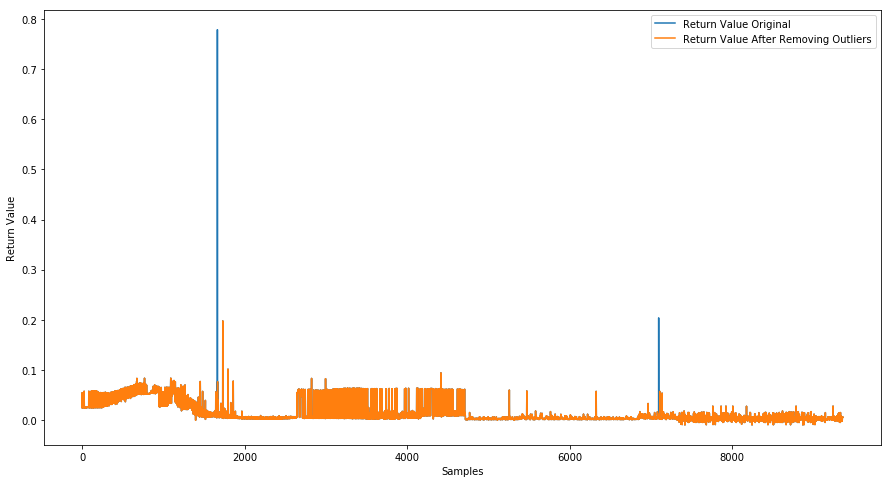

In [73]:
plt.figure(figsize=[15,8]) 
plt.plot(Train_enc['return'],label="Return Value Original")
plt.figure
plt.plot(Train_rem['return'],label="Return Value After Removing Outliers")
plt.legend()
plt.ylabel("Return Value")
plt.xlabel("Samples")
plt.show()

In [74]:
Train_rem.columns

Index(['desk_id', 'sold', 'euribor_rate', 'libor_rate', 'bought',
       'indicator_code', 'hedge_value', 'status', 'return', 'Creation-Start',
       'Sell-Creation', 'office_id_OFF00001001', 'office_id_OFF00001002',
       'pf_category_A', 'pf_category_B', 'pf_category_C', 'pf_category_D',
       'country_code_M', 'country_code_N', 'country_code_T', 'country_code_U',
       'country_code_Z', 'currency_CHF', 'currency_EUR', 'currency_GBP',
       'currency_JPY', 'currency_USD', 'type_A', 'type_B', 'type_C', 'type_D',
       'type_E', 'type_F', 'type_H'],
      dtype='object')

In [75]:
Test_enc.columns

Index(['desk_id', 'sold', 'euribor_rate', 'libor_rate', 'bought',
       'indicator_code', 'hedge_value', 'status', 'Creation-Start',
       'Sell-Creation', 'office_id_OFF00001001', 'office_id_OFF00001002',
       'pf_category_A', 'pf_category_B', 'pf_category_C', 'pf_category_D',
       'country_code_M', 'country_code_N', 'country_code_T', 'country_code_U',
       'country_code_Z', 'currency_CHF', 'currency_EUR', 'currency_GBP',
       'currency_JPY', 'currency_USD', 'type_A', 'type_B', 'type_C', 'type_D',
       'type_E', 'type_F', 'type_H'],
      dtype='object')

# Now Preparing Our Model - XGBoost

In [77]:
Y = Train_rem['return']
X = Train_rem.drop('return', axis = 1)

In [78]:
xg_reg = xgb.XGBRegressor(n_estimators=1600, max_depth=4, seed=1729)

In [79]:
xg_reg.fit(X,Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=1600, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1729, silent=True, subsample=1)

In [80]:
pred = xg_reg.predict(X)
r2_score(pred,Y)

0.99548771104618017

# Visualizing Importance of Features In XGBoost

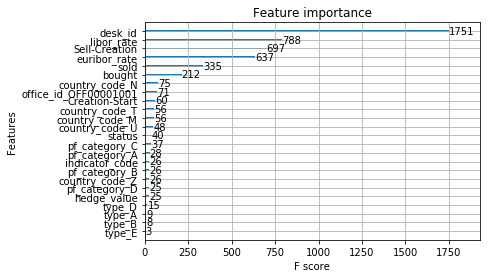

In [81]:
xgb.plot_importance(xg_reg)

# Making Prediction On Test Data

In [82]:
predictions = xg_reg.predict(Test_enc)

# Reporting Results

In [83]:
sub = pd.DataFrame({'portfolio_id': portfolio_id, 'return': predictions})
filename = 'submissison_annual.csv'
sub.to_csv(filename, index=False)
FileLink(filename)               

/home/sparsh/Desktop/SocieteGenerale Brainwaves-2017/submissison_annual.csv